In [2384]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from pandas import DataFrame
import pickle, random
from tqdm import tqdm
from scipy.spatial import KDTree
import matplotlib.pyplot as plt

In [2385]:
#!pwd

In [2386]:
#df0 = pd.read_csv('../spreadsheets/rlhf_20250104_6.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_159nlp.csv') # Best
#df0 = pd.read_csv('../spreadsheets/rlhf_1064_2.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_1072.csv') # 0.05, 0.95, 1.0, 0.999, 0.995, 12000
#df0 = pd.read_csv('../spreadsheets/shufled_rlhf_11rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_12rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_15rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_19rl.csv') # 0.005, 0.75, 0.1, 0.95, 0.999, 12000
#df0 = pd.read_csv('../spreadsheets/rlhf_large_23rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_24rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_25rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_26rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_157nlp.csv') # 0.7, 0.95, 0.5, 0.999, 0.99, 16000
#df0 = pd.read_csv('../spreadsheets/rlhf_large_29rl.csv') # 0.9, 0.9, 0.005, 0.95, 0.999, 10000, 0.9, 0.95, 1.0, 0.99, 0.99, 8000
#df0 = pd.read_csv('../spreadsheets/rlhf_large_30rl.csv') # 
#df0 = pd.read_csv('../spreadsheets/rlhf_large_32rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_33rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_35rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_37rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_27rl2.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_38rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_42rl.csv') # 0.01, 0.99, 1.0, 0.95, 0.99, 16000
#df0 = pd.read_csv('../spreadsheets/rlhf_large_50rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_154nlp_balanced.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_50rl_refined.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_small_154nlp_refined.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_small_12rl_refined.csv') # 0.001, 0.99, 1.0, 0.95, 0.99, 10000
#df0 = pd.read_csv('../spreadsheets/rlhf_large_27rl_refined.csv') # 0.05, 0.95, 0.05, 0.99, 0.95, 8000
#df0 = pd.read_csv('../spreadsheets/rlhf_large_65-66-68rl.csv') # 0.005, 0.85, 0.005, 0.99, 0.997, 6000
df0 = pd.read_csv('../spreadsheets/rlhf_large_99rl.csv')

In [2387]:
df0.head()

,Unnamed: 0,open,high,ema-26,ema-12,low,mean-grad-hist,close,volume,sma-25,long_jcrosk,short_kdj,sma-05,sma-07,sma-compare,is_short,action,imit-action,nlpreds,reward
0,0,138.970000,145.250000,136.447866,134.617469,138.440000,0,141.770000,4.958630e+03,133.971200,1,0,137.642000,137.210000,0,1,go_short,go_long,do_nothing,7.113071
1,1,0.011821,0.011891,0.012238,0.012116,0.011135,1,0.011482,2.062242e+08,0.012127,0,0,0.012085,0.012307,0,0,do_nothing,go_short,do_nothing,-35.788772
2,2,0.089250,0.089320,0.089056,0.088819,0.089250,1,0.089260,2.076000e+03,0.088642,1,0,0.089262,0.089227,0,0,go_long,go_short,do_nothing,30.299614
3,3,0.147040,0.150210,0.147727,0.143828,0.147030,0,0.149020,6.329608e+06,0.144634,0,0,0.150122,0.150167,0,1,go_short,go_short,do_nothing,64.003147
4,4,49.385000,50.595000,49.302116,48.528804,49.325000,0,50.375000,6.648470e+03,48.248200,0,0,49.787000,49.646429,0,1,do_nothing,go_long,do_nothing,-7.181780


In [2388]:
df0['ask'] = df0['close'] * df0['volume']/(df0['close'] + df0['open'])

In [2389]:
df0['bid'] = df0['open'] * df0['volume']/(df0['close'] + df0['open'])

In [2390]:
df0.columns

Index(['Unnamed: 0', 'open', 'high', 'ema-26', 'ema-12', 'low',
       'mean-grad-hist', 'close', 'volume', 'sma-25', 'long_jcrosk',
       'short_kdj', 'sma-05', 'sma-07', 'sma-compare', 'is_short', 'action',
       'imit-action', 'nlpreds', 'reward', 'ask', 'bid'],
      dtype='object')

In [2391]:
df0.head()

,Unnamed: 0,open,high,ema-26,ema-12,low,mean-grad-hist,close,volume,sma-25,...,sma-05,sma-07,sma-compare,is_short,action,imit-action,nlpreds,reward,ask,bid
0,0,138.970000,145.250000,136.447866,134.617469,138.440000,0,141.770000,4.958630e+03,133.971200,...,137.642000,137.210000,0,1,go_short,go_long,do_nothing,7.113071,2.504043e+03,2.454587e+03
1,1,0.011821,0.011891,0.012238,0.012116,0.011135,1,0.011482,2.062242e+08,0.012127,...,0.012085,0.012307,0,0,do_nothing,go_short,do_nothing,-35.788772,1.016121e+08,1.046121e+08
2,2,0.089250,0.089320,0.089056,0.088819,0.089250,1,0.089260,2.076000e+03,0.088642,...,0.089262,0.089227,0,0,go_long,go_short,do_nothing,30.299614,1.038058e+03,1.037942e+03
3,3,0.147040,0.150210,0.147727,0.143828,0.147030,0,0.149020,6.329608e+06,0.144634,...,0.150122,0.150167,0,1,go_short,go_short,do_nothing,64.003147,3.185970e+06,3.143638e+06
4,4,49.385000,50.595000,49.302116,48.528804,49.325000,0,50.375000,6.648470e+03,48.248200,...,49.787000,49.646429,0,1,do_nothing,go_long,do_nothing,-7.181780,3.357224e+03,3.291246e+03


In [2392]:
df0.columns

Index(['Unnamed: 0', 'open', 'high', 'ema-26', 'ema-12', 'low',
       'mean-grad-hist', 'close', 'volume', 'sma-25', 'long_jcrosk',
       'short_kdj', 'sma-05', 'sma-07', 'sma-compare', 'is_short', 'action',
       'imit-action', 'nlpreds', 'reward', 'ask', 'bid'],
      dtype='object')

In [2393]:
#df0.drop(['Unnamed: 0'], axis=1, inplace=True)

In [2394]:
#df0['nlpreds'].value_counts()

In [2395]:
#action_mapping = {"go_long": 0, "go_short": 1}

In [2396]:
def prep_data(df: DataFrame) -> DataFrame:
    train_data = pd.DataFrame()
    for col in df.columns:
        col_name = col.split(' ')[0]
        train_data[f'{col_name}'] = df[col]

    return train_data

In [2397]:
train_data = df0 #prep_data(df0)

In [2398]:
train_data.head(2)

,Unnamed: 0,open,high,ema-26,ema-12,low,mean-grad-hist,close,volume,sma-25,...,sma-05,sma-07,sma-compare,is_short,action,imit-action,nlpreds,reward,ask,bid
0,0,138.970000,145.250000,136.447866,134.617469,138.440000,0,141.770000,4.958630e+03,133.971200,...,137.642000,137.210000,0,1,go_short,go_long,do_nothing,7.113071,2.504043e+03,2.454587e+03
1,1,0.011821,0.011891,0.012238,0.012116,0.011135,1,0.011482,2.062242e+08,0.012127,...,0.012085,0.012307,0,0,do_nothing,go_short,do_nothing,-35.788772,1.016121e+08,1.046121e+08


In [2399]:
train_data.columns

Index(['Unnamed: 0', 'open', 'high', 'ema-26', 'ema-12', 'low',
       'mean-grad-hist', 'close', 'volume', 'sma-25', 'long_jcrosk',
       'short_kdj', 'sma-05', 'sma-07', 'sma-compare', 'is_short', 'action',
       'imit-action', 'nlpreds', 'reward', 'ask', 'bid'],
      dtype='object')

In [2400]:
new_cols = ['ask','bid','sma-compare','is_short']

In [2401]:
# Encode actions into numerical values
action_mapping = {"go_long": 0, "go_short": 1, "do_nothing": 2}
train_data["action_num"] = train_data["action"].map(action_mapping)

In [2402]:
train_data.head(2)

,Unnamed: 0,open,high,ema-26,ema-12,low,mean-grad-hist,close,volume,sma-25,...,sma-07,sma-compare,is_short,action,imit-action,nlpreds,reward,ask,bid,action_num
0,0,138.970000,145.250000,136.447866,134.617469,138.440000,0,141.770000,4.958630e+03,133.971200,...,137.210000,0,1,go_short,go_long,do_nothing,7.113071,2.504043e+03,2.454587e+03,1
1,1,0.011821,0.011891,0.012238,0.012116,0.011135,1,0.011482,2.062242e+08,0.012127,...,0.012307,0,0,do_nothing,go_short,do_nothing,-35.788772,1.016121e+08,1.046121e+08,2


In [2403]:
# Define RL parameters
#states = train_data[["sma-05", "sma-07", "sma-25", "sma-compare", "is_short"]].values  # Include binary_state
states = train_data[new_cols].values
actions = list(action_mapping.values())  # Action space
rewards = train_data["reward"].values  # Rewards
n_states = states.shape[0]
n_actions = len(actions)

In [2404]:
# Initialize Q-table
q_table = np.zeros((n_states, n_actions))

In [2405]:
Hyperparameters = [
    [0.01, 0.95, 0.997, 0.997, 0.995, 26000],
    [0.005,0.85,0.99,0.99,0.997,6000],
    [0.2, 0.99, 0.01, 0.99, 0.997, 9000],
    [0.005, 0.85, 0.005, 0.99, 0.997, 6000],
    [0.05, 0.95, 0.05, 0.99, 0.95, 8000],
    [0.001, 0.99, 1.0, 0.95, 0.99, 10000],
    [0.1, 0.9, 0.99, 0.99, 0.995, 4000],
    [0.005, 0.75, 0.1, 0.95, 0.999, 12000],
    [0.001, 0.75, 0.99, 0.99, 0.99, 30000],
    [1, 0.75, 0.005, 0.95, 0.95, 22000],
    [0.01, 0.99, 1.0, 0.95, 0.99, 16000],
    [0.7, 0.99, 1.0, 0.95, 0.997, 8000],
    [0.01, 0.95, 1.0, 0.997, 0.995, 26000],
    [0.25, 0.95, 0.01, 0.997, 0.999, 14000],
    [0.5, 0.85, 0.5, 0.997, 0.997, 14000],
    [0.01, 0.85, 0.01, 0.95, 0.95, 12000],
    [0.9, 0.99, 0.5, 0.995, 0.95, 12000],
    [0.05, 0.9, 0.5, 0.95, 0.999, 4000],
    [0.05, 0.99, 0.5, 0.99, 0.997, 6000],
    [1, 0.75, 0.05, 0.999, 0.999, 10000],
    [0.9, 0.95, 1.0, 0.99, 0.99, 8000],
    [0.25, 0.75, 0.01, 0.995, 0.999, 20000],
    [0.3, 0.75, 1.0, 0.995, 0.99, 10000],
    [1, 0.9, 1.0, 0.999, 0.999, 10000],
    [0.7, 0.75, 1.0, 0.97, 0.999, 28000],
    [0.05, 0.95, 1.0, 0.999, 0.995, 12000],
    [0.7, 0.95, 0.5, 0.999, 0.99, 16000],
    [0.25, 0.95, 1.0, 0.99, 0.99, 10000],
    [0.25, 0.99, 0.01, 0.997, 0.99, 8000],
    [1, 0.95, 0.1, 0.96, 0.96, 12000],
    [0.9, 0.9, 0.005, 0.95, 0.999, 10000],
    [1, 0.9, 1.0, 0.99, 0.99, 11000],
    [0.01, 0.9, 0.5, 0.999, 0.999, 1500]

]

#print(*Hyperparameters[0])
'''
alpha = 1
gamma = 0.95
epsilon = 0.1
min_epsilon = 0.96
decay_rate = 0.96
n_episodes = 12000
'''

alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes = Hyperparameters[6] # Hyperparameters[9] # Hyperparameters[22] #Hyperparameters[6]



In [2406]:
def create_state_index_mapping(df):
    state_to_index = {}
    for idx, row in df.iterrows():
        state = (row['ask'], row['bid'], row['sma-compare'], row['is_short'])
        state_to_index[state] = idx
    return state_to_index

# Assuming 'df' is your dataframe used during training
state_to_index = create_state_index_mapping(train_data)

# Save the state_to_index dictionary for later use
np.save('bids_state_to_index.npy', state_to_index)


In [2407]:
# Helper function to choose an action using epsilon-greedy
def choose_action(state, epsilon):
    if np.random.uniform(0, 1) < epsilon:
        return np.random.randint(0, n_actions)  # Explore: random action
    else:
        return np.argmax(q_table[state])  # Exploit: best known action

In [ ]:
'''
# Load the best episode transitions
best_episode_transitions = np.load("best_bids_episode_trasitions.npy", allow_pickle=True)

# Optionally, pre-train the Q-table using the best episode
for state, action, reward, next_state in best_episode_transitions:
    best_next_action = np.argmax(q_table[next_state])
    q_table[state, action] += alpha * (reward + gamma * q_table[next_state, best_next_action] - q_table[state, action])

# Load the previously saved Q-table and best episode transitions
best_q_table = np.load("best_bids_q_table.npy")  # Load the best Q-table
best_episode_transitions = np.load("best_bids_episode_trasitions.npy", allow_pickle=True).tolist()  # Load best transitions
'''

IndexError: index 632 is out of bounds for axis 0 with size 632

Evaluating results per episode...:   1%|          | 37/4000 [00:00<00:10, 364.76it/s]

Episode 0/4000 - Total Reward: 10847.303968579998, Epsilon: 0.99


Evaluating results per episode...:  11%|█         | 448/4000 [00:01<00:10, 343.19it/s]

Episode 400/4000 - Total Reward: 3487.979298549999, Epsilon: 0.99


Evaluating results per episode...:  22%|██▏       | 867/4000 [00:02<00:09, 344.95it/s]

Episode 800/4000 - Total Reward: 10796.17870944, Epsilon: 0.99


Evaluating results per episode...:  32%|███▏      | 1271/4000 [00:03<00:07, 344.50it/s]

Episode 1200/4000 - Total Reward: 6359.390306120003, Epsilon: 0.99


Evaluating results per episode...:  41%|████      | 1635/4000 [00:04<00:06, 341.18it/s]

Episode 1600/4000 - Total Reward: 3231.351781999999, Epsilon: 0.99


Evaluating results per episode...:  51%|█████▏    | 2054/4000 [00:05<00:05, 380.44it/s]

Episode 2000/4000 - Total Reward: 3478.135701089999, Epsilon: 0.99


Evaluating results per episode...:  62%|██████▏   | 2466/4000 [00:07<00:04, 365.93it/s]

Episode 2400/4000 - Total Reward: 11097.578227940003, Epsilon: 0.99


Evaluating results per episode...:  71%|███████   | 2844/4000 [00:08<00:03, 370.67it/s]

Episode 2800/4000 - Total Reward: 4326.3281855299965, Epsilon: 0.99


Evaluating results per episode...:  82%|████████▏ | 3277/4000 [00:09<00:02, 339.17it/s]

Episode 3200/4000 - Total Reward: 1941.78848607, Epsilon: 0.99


Evaluating results per episode...:  91%|█████████ | 3638/4000 [00:10<00:01, 342.13it/s]

Episode 3600/4000 - Total Reward: 2578.1618250600004, Epsilon: 0.99


Evaluating results per episode...: 100%|██████████| 4000/4000 [00:11<00:00, 347.97it/s]


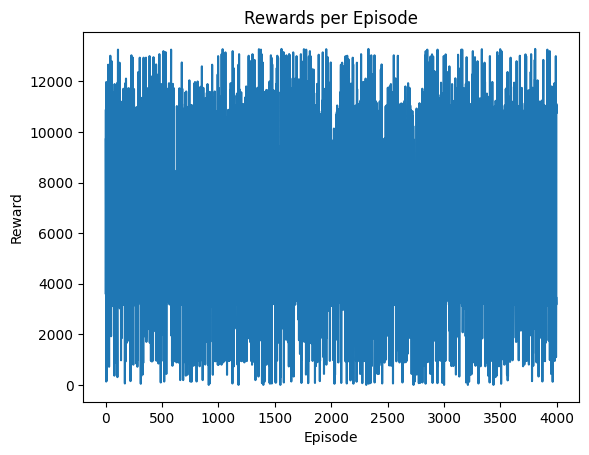

Best Episode Reward: 13283.816152519996
Best Episode Transitions: [(0, 2, 10.00895541, 1), (1, 0, 17.80269532, 2), (2, 1, 58.85809089, 3), (3, 1, 38.54910181, 4), (4, 2, 10.14014471, 5)] ...
Best Episode Hyperparameters: {'alpha': 0.1, 'gamma': 0.9, 'epsilon': 0.99, 'min_epsilon': 0.99, 'decay_rate': 0.995, 'n_episodes': 4000}


In [ ]:
# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

# Define hyperparameters

# Initialize lists to store rewards and transitions per episode
rewards_per_episode = []
best_episode_transitions = [] # Uncomment this if you have previous episode trasitions
best_q_table = None
best_total_reward = float('-inf')  # Initialize with negative infinity
best_hyperparameters = {}  # Dictionary to store hyperparameters of best episode

for episode in tqdm(range(n_episodes), desc="Evaluating results per episode..."):
    current_state = np.random.randint(0, n_states)  # Random initial state
    total_reward = 0  # Initialize total reward for the current episode
    episode_transitions = []  # Store (state, action, reward, next_state) tuples for this episode

    while current_state < n_states - 1:
        action = choose_action(current_state, epsilon)
        next_state = current_state + 1  # This depends on your environment logic
        reward = rewards[next_state]

        best_next_action = np.argmax(q_table[next_state])
        q_table[current_state, action] += alpha * (
            reward + gamma * q_table[next_state, best_next_action] - q_table[current_state, action]
        )

        total_reward += reward  # Accumulate reward
        episode_transitions.append((current_state, action, reward, next_state))
        current_state = next_state  # Move to next state

    rewards_per_episode.append(total_reward)  # Store total reward for the current episode

    # Check if this is the best episode so far
    if total_reward > best_total_reward:
        best_total_reward = total_reward
        best_episode_transitions = episode_transitions.copy()
        best_q_table = q_table.copy()

        # Store the hyperparameters at the best episode
        best_hyperparameters = {
            "alpha": alpha,
            "gamma": gamma,
            "epsilon": epsilon,
            "min_epsilon": min_epsilon,
            "decay_rate": decay_rate,
            "n_episodes": n_episodes
        }

    # Decay epsilon
    epsilon = max(min_epsilon, epsilon * decay_rate)

    # Optional: Log progress
    if episode % 400 == 0:  
        print(f"Episode {episode}/{n_episodes} - Total Reward: {total_reward}, Epsilon: {epsilon}")

# Save the best episode's Q-table
np.save("best_bids_q_table.npy", q_table)
# Save the best episode's transitions
np.save("best_bids_episode_trasitions.npy", np.array(best_episode_transitions, dtype=object))

# Plot the rewards per episode
plt.plot(rewards_per_episode)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Rewards per Episode')
plt.show()

# Print best episode results
print(f"Best Episode Reward: {best_total_reward}")
print(f"Best Episode Transitions: {best_episode_transitions[:5]} ...")  # Show first 5 transitions
print(f"Best Episode Hyperparameters: {best_hyperparameters}")

In [ ]:
def load_q_table(file_path):
    return np.load(file_path)

def load_state_index_mapping(file_path):
    return np.load(file_path, allow_pickle=True).item()

loaded_mapping = load_state_index_mapping(file_path="bids_state_to_index.npy")
loaded_qtable = load_q_table(file_path="bids_q_table.npy")

In [ ]:
#state = (row['open'], row['high'], row['ema-26'], row['ema-12'], row['low'], \
#                 row['mean-grad-hist'], row['close'], row['volume'], row['sma-25'], \
#                 row['long_jcrosk'], row['short_kdj'], row['sma-compare'], row['is_short'])

def prep_state(
                ask: float, bid: float, sma_compare: int, is_short: int
            ):
    state = np.array([[ask, bid, sma_compare, is_short]])
    if not np.all(np.isfinite(state)):
        state = np.nan_to_num(state, nan=0.0, posinf=0.0, neginf=0.0)
    return state


In [ ]:

def predict_action(state, q_table, state_to_index, action_mapping, default_action: str = None):
    state_tuple = tuple(state.flatten())

    state_index = state_to_index.get(state_tuple, -1)

    if not state_index == -1:
        try:
            q_values = q_table[state_index]
        except ValueError as e:
            print(e)
            #return default_action
    else:
        state_tuples = list(state_to_index.keys())
        kdtree = KDTree(state_tuples)
        distance, index = kdtree.query(state.flatten())
        nearest_state_tuple = state_tuples[index]
        new_state_index = state_to_index[nearest_state_tuple]
        q_values = loaded_qtable[new_state_index]
    
    #q_values = q_table[state_index]
    best_action_index = np.argmax(q_values)
    action = [action for action, index in action_mapping.items() if index == best_action_index][0]
    return action

In [ ]:
# Predict an entire range
def predict_range(df: DataFrame = train_data) -> DataFrame:
    for idx, row in df.iterrows():
        state = row[['ask','bid','sma-compare', 'is_short']].values
        action = predict_action(state, q_table, state_to_index, action_mapping)
        df.loc[idx, "predicted_action"] = action
    if (df['predicted_action'].nunique() < 2):
        print("Only one action predicted, please check the Q-table")
    return df

In [ ]:
train_data = predict_range(train_data)

In [ ]:
if (train_data['predicted_action'].nunique() < 2):
    raise ValueError("Model predictions are invalid")

In [ ]:
train_data['predicted_action'].value_counts()

predicted_action
go_long       413
go_short      282
do_nothing    187
Name: count, dtype: int64

In [ ]:
m = train_data[(train_data['predicted_action'] == 'go_long') & (train_data['reward'] > 0)]
m['is_short'].value_counts()

is_short
0    220
1     70
Name: count, dtype: int64

In [ ]:
longs = dict(m['is_short'].value_counts().items()).get(0)
print(longs)
shorts = dict(m['is_short'].value_counts().items()).get(1)
print(shorts)

220
70


In [ ]:
# Performance measures
# Initialize cumulative rewards
cumulative_predicted_reward = 0
cumulative_actual_reward = 0

# Iterate through states to calculate rewards
for state_index in range(n_states - 1):
    # Predicted action from Q-table
    predicted_action = np.argmax(q_table[state_index])  # Best action for the current state
    # Actual action from the ground truth
    actual_action = train_data["action_num"].iloc[state_index]

    # Get reward for predicted action only if it matches the actual action
    if predicted_action == actual_action:
        predicted_reward = rewards[state_index + 1]  # Reward for the correct prediction
        cumulative_predicted_reward += predicted_reward

    # Get actual reward for the ground truth action
    actual_reward = rewards[state_index + 1]
    cumulative_actual_reward += actual_reward

    # Optional: Log progress
    if state_index % 100 == 0:  # Adjust logging frequency as needed
        print(f"Processed state {state_index}/{n_states - 1}")
        print(f"Current Predicted Reward: {cumulative_predicted_reward}")
        print(f"Current Actual Reward: {cumulative_actual_reward}")

# Print results
print(f"Cumulative Predicted Reward: {cumulative_predicted_reward}")
print(f"Cumulative Actual Reward: {cumulative_actual_reward}")

# Optionally calculate efficiency
efficiency = (
    ((cumulative_predicted_reward - cumulative_actual_reward) / abs(cumulative_actual_reward)) * 100
    if cumulative_actual_reward != 0
    else 0
)
print(f"Prediction Efficiency: {efficiency:.2f}%")



Processed state 0/881
Current Predicted Reward: 0
Current Actual Reward: 10.00895541
Processed state 100/881
Current Predicted Reward: 254.5386666800001
Current Actual Reward: 2335.1118273500006
Processed state 200/881
Current Predicted Reward: 675.5334374500002
Current Actual Reward: 3352.692738069999
Processed state 300/881
Current Predicted Reward: 1047.8715859200001
Current Actual Reward: 5062.91212276
Processed state 400/881
Current Predicted Reward: 1456.1212339999995
Current Actual Reward: 7861.499513030003
Processed state 500/881
Current Predicted Reward: 2011.4356584000002
Current Actual Reward: 9706.235351229994
Processed state 600/881
Current Predicted Reward: 1984.8981875700006
Current Actual Reward: 9859.951298639997
Processed state 700/881
Current Predicted Reward: 1551.7063812100005
Current Actual Reward: 9725.654615669997
Processed state 800/881
Current Predicted Reward: 2498.82325669
Current Actual Reward: 11522.324187689994
Cumulative Predicted Reward: 2250.8301151100

In [ ]:
# Accuracy
correct_predictions = 0
for state_index in range(n_states):
    predicted_action = np.argmax(q_table[state_index])  # Predicted action
    actual_action = train_data["action_num"].iloc[state_index]  # Actual action
    if predicted_action == actual_action:
        correct_predictions += 1

accuracy = correct_predictions / n_states
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 36.28%


In [ ]:
# Confusion matrix
y_true = train_data["action_num"]  # Actual actions
y_pred = [np.argmax(q_table[state_index]) for state_index in range(n_states)]  # Predicted actions

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[199 137  90]
 [ 79  66  53]
 [114  89  55]]


In [ ]:
def confusion_accuracy(conf_matrix, n_states):
    # True Positives (TP): Diagonal elements of the confusion matrix
    TP = conf_matrix[0][0] + conf_matrix[1][1] + conf_matrix[2][2]
    # **True Positives**: 16 (class 0), 0 (class 1), 0 (class 2)
    return TP*100/n_states

In [ ]:
#con_acc = confusion_accuracy(cm, n_states=n_states)
#print(f"confusion accuracy: {con_acc:.2f}%")

In [ ]:
df0['predicted_action'].value_counts()

predicted_action
go_long       413
go_short      282
do_nothing    187
Name: count, dtype: int64

In [ ]:
def action_reward(action: str, is_short: int):
    m = train_data[(train_data['predicted_action'] == f'{action}') & (train_data['is_short'] == is_short)]
    counts = m['is_short'].value_counts()
    total_reward = m['reward'].cumsum()[-1:].values[0]
    wins = len(m[m['reward'] > 0])
    losses = len(m[m['reward'] <= 0])
    return {
        'counts': counts.get(is_short),
        'total reward': total_reward,
        'winrate': f'{wins * 100 / (losses + wins):.2f}%',
        'per trade profit': m[m['reward'] > 0]['reward'].sum() / wins,
        'per trade loss': m[m['reward'] <= 0]['reward'].sum() / losses
    }

In [ ]:
print(action_reward('go_long', 1)) # go_short 1

{'counts': 147, 'total reward': 100.78274780000066, 'winrate': '47.62%', 'per trade profit': 50.470235958857145, 'per trade loss': -44.57316583532468}


In [ ]:
dirs = [0,1]
for action in action_mapping.keys():
    for is_short in dirs:
        try:
            print(f'{action} {is_short}: {action_reward(action, is_short)}')
        except IndexError as e:
            print(e)

go_long 0: {'counts': 266, 'total reward': 7167.777708260003, 'winrate': '82.71%', 'per trade profit': 43.573779676136375, 'per trade loss': -52.575083054130424}
go_long 1: {'counts': 147, 'total reward': 100.78274780000066, 'winrate': '47.62%', 'per trade profit': 50.470235958857145, 'per trade loss': -44.57316583532468}
go_short 0: {'counts': 140, 'total reward': 2377.94125736, 'winrate': '70.71%', 'per trade profit': 43.50055089434343, 'per trade loss': -47.039348321463414}
go_short 1: {'counts': 142, 'total reward': 2368.199397900001, 'winrate': '57.75%', 'per trade profit': 63.884153657804866, 'per trade loss': -47.838353367333326}
do_nothing 0: {'counts': 103, 'total reward': 1811.2712294699995, 'winrate': '78.64%', 'per trade profit': 37.25376836345679, 'per trade loss': -54.83109127136363}
do_nothing 1: {'counts': 84, 'total reward': -482.12106751000016, 'winrate': '42.86%', 'per trade profit': 47.62610971944444, 'per trade loss': -45.76377119604166}


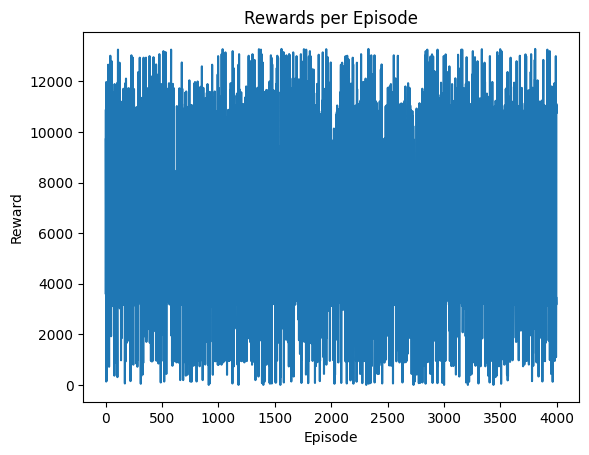

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have a list of rewards for each episode
#rewards_per_episode = [...]  # Populate this with your actual data

plt.plot(rewards_per_episode)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Rewards per Episode')
plt.show()


In [ ]:
# Tuning

def train_q_learning(alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes, n_states, n_actions, rewards):
    q_table = np.zeros((n_states, n_actions))
    rewards_per_episode = []

    for episode in range(n_episodes):
        current_state = np.random.randint(0, n_states)
        total_reward = 0

        while current_state < n_states - 1:
            if np.random.uniform(0, 1) < epsilon:
                action = np.random.randint(0, n_actions)
            else:
                action = np.argmax(q_table[current_state])

            next_state = current_state + 1  # Adjust based on environment logic
            reward = rewards[next_state]

            best_next_action = np.argmax(q_table[next_state])
            q_table[current_state, action] += alpha * (
                reward + gamma * q_table[next_state, best_next_action] - q_table[current_state, action]
            )

            total_reward += reward
            current_state = next_state

        rewards_per_episode.append(total_reward)
        epsilon = max(min_epsilon, epsilon * decay_rate) # default min_epsilon = 0.01

    return q_table, rewards_per_episode


In [ ]:

def evaluate_q_learning_reward_weighted(q_table, n_states, train_data, rewards):
    correct_predictions = 0
    total_reward = 0
    reward_weighted_accuracy = []

    # Add tqdm for progress visualization
    for state_index in tqdm(range(n_states), desc="Evaluating States"):
        predicted_action = np.argmax(q_table[state_index])  # Predicted action
        actual_action = train_data["action_num"].iloc[state_index]  # Actual action
        reward = rewards[state_index]  # Reward for the action

        if predicted_action == actual_action:
            correct_predictions += 1
            total_reward += reward

        accuracy = correct_predictions / (state_index + 1)
        reward_weighted_accuracy.append(total_reward / (state_index + 1))

        # Optional: Log progress
        if state_index % 100 == 0:
            print(f"Processed state {state_index}/{n_states} - Accuracy: {accuracy * 100:.2f}%, Reward-weighted Accuracy: {reward_weighted_accuracy[-1]}")

    final_reward_weighted_accuracy = total_reward / n_states
    return final_reward_weighted_accuracy * 100



In [ ]:
'''
def random_search_reward_weighted(n_iter, param_grid, n_states, n_actions, rewards, train_data):
    best_params = None
    best_reward_weighted_accuracy = float('-inf')

    for _ in tqdm(range(n_iter), desc="Searching for params ..."):
        alpha = random.choice(param_grid['alpha'])
        gamma = random.choice(param_grid['gamma'])
        epsilon = random.choice(param_grid['epsilon'])
        min_epsilon = random.choice(param_grid['decay_rate'])
        decay_rate = random.choice(param_grid['decay_rate'])
        n_episodes = random.choice(param_grid['n_episodes'])

        q_table, _ = train_q_learning(alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes, n_states, n_actions, rewards)
        reward_weighted_accuracy = evaluate_q_learning_reward_weighted(q_table, n_states, train_data, rewards)

        if reward_weighted_accuracy > best_reward_weighted_accuracy:
            best_reward_weighted_accuracy = reward_weighted_accuracy
            best_params = (alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes)

        print(f"Iteration Reward-weighted Accuracy: {reward_weighted_accuracy:.2f}%, Best Reward-weighted Accuracy: {best_reward_weighted_accuracy:.2f}%")

    return best_params, best_reward_weighted_accuracy

# Define the parameter grid
param_grid = {
    'alpha': [0.01, 0.05, 0.1, 0.2, 0.25, 0.3, 0.5, 0.7, 0.9, 1],
    'gamma': [0.75, 0.85, 0.9, 0.95, 0.99],
    'epsilon': [1.0, 0.5, 0.1, 0.05, 0.01, 0.005],
    'min_epsilon': [0.05, 0.01, 0.005, 0.001, 0.001],
    'decay_rate': [0.95, 0.99, 0.995, 0.997, 0.999],
    'n_episodes': [1500, 4000,6000, 8000, 9000, 10000, 11000, 12000]
}

# Perform Random Search
best_params, best_reward_weighted_accuracy = random_search_reward_weighted(50, param_grid, n_states, n_actions, rewards, train_data)
print(f"Best Hyperparameters: {best_params}")
print(f"Best Reward-weighted Accuracy: {best_reward_weighted_accuracy:.2f}%")

'''

'\ndef random_search_reward_weighted(n_iter, param_grid, n_states, n_actions, rewards, train_data):\n    best_params = None\n    best_reward_weighted_accuracy = float(\'-inf\')\n\n    for _ in tqdm(range(n_iter), desc="Searching for params ..."):\n        alpha = random.choice(param_grid[\'alpha\'])\n        gamma = random.choice(param_grid[\'gamma\'])\n        epsilon = random.choice(param_grid[\'epsilon\'])\n        min_epsilon = random.choice(param_grid[\'decay_rate\'])\n        decay_rate = random.choice(param_grid[\'decay_rate\'])\n        n_episodes = random.choice(param_grid[\'n_episodes\'])\n\n        q_table, _ = train_q_learning(alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes, n_states, n_actions, rewards)\n        reward_weighted_accuracy = evaluate_q_learning_reward_weighted(q_table, n_states, train_data, rewards)\n\n        if reward_weighted_accuracy > best_reward_weighted_accuracy:\n            best_reward_weighted_accuracy = reward_weighted_accuracy\n        

In [ ]:
def evaluate_q_learning_prediction_efficiency(q_table, n_states, train_data, rewards):
    # Initialize cumulative rewards
    cumulative_predicted_reward = 0
    cumulative_actual_reward = 0

    # Iterate through states to calculate rewards
    for state_index in range(n_states - 1):
        # Predicted action from Q-table
        predicted_action = np.argmax(q_table[state_index])  # Best action for the current state
        # Actual action from the ground truth
        actual_action = train_data["action_num"].iloc[state_index]

        # Get reward for predicted action only if it matches the actual action
        if predicted_action == actual_action:
            predicted_reward = rewards[state_index + 1]  # Reward for the correct prediction
            cumulative_predicted_reward += predicted_reward

        # Get actual reward for the ground truth action
        actual_reward = rewards[state_index + 1]
        cumulative_actual_reward += actual_reward
    return cumulative_predicted_reward

In [ ]:
train_data.columns

Index(['open', 'high', 'ema-26', 'ema-12', 'low', 'mean-grad-hist', 'close',
       'volume', 'sma-05', 'sma-07', 'sma-25', 'long_jcrosk', 'short_kdj',
       'sma-compare', 'ask', 'bid', 'is_short', 'nlpreds', 'action',
       'predicted_action', 'reward', 'refined-action', 'action_num'],
      dtype='object')

In [ ]:
'''
def random_search_prediction_efficiency(n_iter, param_grid, n_states, n_actions, rewards, train_data):
    best_params = None
    best_cumulative_pred_reward = float('-inf')

    for _ in tqdm(range(n_iter), desc="Searching for params ..."):
        alpha = random.choice(param_grid['alpha'])
        gamma = random.choice(param_grid['gamma'])
        epsilon = random.choice(param_grid['epsilon'])
        min_epsilon = random.choice(param_grid['decay_rate'])
        decay_rate = random.choice(param_grid['decay_rate'])
        n_episodes = random.choice(param_grid['n_episodes'])

        q_table, _ = train_q_learning(alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes, n_states, n_actions, rewards)
        cumulative_pred_reward = evaluate_q_learning_prediction_efficiency(q_table, n_states, train_data, rewards)

        if cumulative_pred_reward > best_cumulative_pred_reward:
            best_cumulative_pred_reward = cumulative_pred_reward
            best_params = (alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes)

        print(f"Iteration cumulative predicted reward: {cumulative_pred_reward:.2f}%, Best cumulative predicted reward: {best_cumulative_pred_reward:.2f}%")

    return best_params, best_cumulative_pred_reward

# Define the parameter grid
param_grid = {
    'alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.25, 0.3, 0.5, 0.7, 0.9, 1],
    'gamma': [0.75, 0.85, 0.9, 0.95, 0.99],
    'epsilon': [1.0, 0.5, 0.1, 0.05, 0.01, 0.005],
    'min_epsilon': [0.05, 0.01, 0.005, 0.001, 0.001],
    'decay_rate': [0.95, 0.99, 0.995, 0.997, 0.999],
    'n_episodes': [1500, 4000,6000, 8000, 9000, 10000, 11000, 12000, 14000, 16000, 18000, 20000, 22000, 24000, 26000, 28000, 30000]
}
# 1500, 4000,6000, 8000, 9000, 10000, 11000, 
# Perform Random Search
best_params, best_cumulative_pred_reward = random_search_prediction_efficiency(50, param_grid, n_states, n_actions, rewards, train_data)
print(f"Best Hyperparameters: {best_params}")
print(f"Best cumulative predicted reward: {best_cumulative_pred_reward:.2f}%")
'''

'\ndef random_search_prediction_efficiency(n_iter, param_grid, n_states, n_actions, rewards, train_data):\n    best_params = None\n    best_cumulative_pred_reward = float(\'-inf\')\n\n    for _ in tqdm(range(n_iter), desc="Searching for params ..."):\n        alpha = random.choice(param_grid[\'alpha\'])\n        gamma = random.choice(param_grid[\'gamma\'])\n        epsilon = random.choice(param_grid[\'epsilon\'])\n        min_epsilon = random.choice(param_grid[\'decay_rate\'])\n        decay_rate = random.choice(param_grid[\'decay_rate\'])\n        n_episodes = random.choice(param_grid[\'n_episodes\'])\n\n        q_table, _ = train_q_learning(alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes, n_states, n_actions, rewards)\n        cumulative_pred_reward = evaluate_q_learning_prediction_efficiency(q_table, n_states, train_data, rewards)\n\n        if cumulative_pred_reward > best_cumulative_pred_reward:\n            best_cumulative_pred_reward = cumulative_pred_reward\n        

In [ ]:
#colsa = ['ask','bid','sma-05', 'sma-07', 'sma-25','sma-compare','is_short', 'action', 'nlpreds', 'predicted_action','reward']
colsa = ['open', 'high', 'ema-26', 'ema-12', 'low', \
            'mean-grad-hist', 'close', 'volume', 'sma-05', 'sma-07', 'sma-25', 'long_jcrosk', 'short_kdj', \
            'sma-compare', 'ask', 'bid', 'is_short', 'nlpreds', 'action', 'predicted_action', 'reward'
        ]
learn_df = train_data[colsa]

In [ ]:
def split_action(action: str):
    return ' '.join(action.split('_'))

In [ ]:
#learn_df.loc[:,['predicted_action']] = learn_df['predicted_action'] #.apply(split_action)

In [ ]:
learn_df.head()

,open,high,ema-26,ema-12,low,mean-grad-hist,close,volume,sma-05,sma-07,...,long_jcrosk,short_kdj,sma-compare,ask,bid,is_short,nlpreds,action,predicted_action,reward
0,274.0000,328.00000,266.507920,258.173616,272.0500,0,290.55000,351222.06,273.19000,269.764286,...,1,0,0,1.807591e+05,1.704629e+05,0,do_nothing,go_short,go_long,60.035121
1,0.0521,0.05235,0.054865,0.055860,0.0508,1,0.05225,3619710.00,0.05416,0.054593,...,0,0,1,1.812457e+06,1.807253e+06,0,go_long,go_long,go_short,10.008955
2,2.0264,2.05090,1.997018,1.973731,2.0258,0,2.04050,2861273.50,2.01406,2.012229,...,0,0,0,1.435597e+06,1.425677e+06,0,do_nothing,go_short,go_short,17.802695
3,0.8075,0.81810,0.811329,0.815042,0.8050,0,0.81610,115912.00,0.81028,0.810757,...,0,0,1,5.826299e+04,5.764901e+04,1,go_long,go_long,go_long,58.858091
4,7.1500,7.15400,7.183519,7.247633,7.0920,1,7.11000,17426.30,7.15340,7.161429,...,0,0,1,8.688709e+03,8.737591e+03,1,go_long,go_long,go_short,38.549102


In [ ]:
learn_df.to_csv('/home/defi/Desktop/portfolio/projects/python/pipeline_defi/lean_df_99rl.csv', index=False)

In [ ]:
learn_df['predicted_action'].value_counts()

predicted_action
go_long       413
go_short      282
do_nothing    187
Name: count, dtype: int64